# NUAGE COMPTA ET LA FACTURE S'ANALYSA
# Application du modèle

## 0. Import des librairies

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
import keras
from keras import metrics
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation
import os
import pickle
import cv2
import imutils
from imutils.contours import sort_contours

from src import fonctions

## 1. Chargement du modèle

In [4]:
# model = pickle.load(open("mon_model.h5","rb"))
model = load_model("data/model.h5")
print("Modèle chargé!")


OSError: Unable to open file (unable to open file: name = 'data/model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

## 2. TEST 1 ---> 1 image (coupée via photoshop)

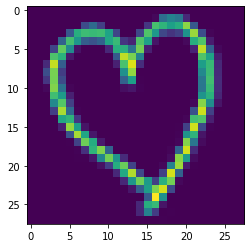

In [3]:
choix = r"assets\COEUR-thomas.png"
test_image = image.load_img(choix, target_size = (28,28), grayscale = True)
plt.imshow(test_image)
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)

In [4]:
resultat = model.predict(test_image)
resultat = fonctions.get_result(resultat)
print(f"La lettre correspondante est: {resultat}")

La lettre correspondante est: ♡


## 3. TEST 2 ---> image d'entrainement " FORMATION DATA IA <3 "

In [5]:
imagePath = 'assets\imagedentrainement.jpeg'

In [6]:
### Je charge mon image d'entrée à partir de la variable "imagePath" puis je la convertie en niveau de gris ###

image = cv2.imread(imagePath)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.medianBlur(gray,5)

In [7]:
### Détection des contours ###

blurred = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
edged = cv2.Canny(blurred, 170, 255)
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sort_contours(cnts, method="left-to-right")[0]

In [8]:
### Initialisation de la liste des contours ###

chars = []

In [9]:
### Détection des ROI ###

for c in cnts:
    
    (x, y, w, h) = cv2.boundingRect(c)
    
    if (w >= 5) and (h >= 15):
        
        roi = gray[y:y + h, x:x + w]
        thresh = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        (tH, tW) = thresh.shape
        
        if tW > tH:
            thresh = imutils.resize(thresh, width=28)
        else:
            thresh = imutils.resize(thresh, height=28)

        padded = cv2.copyMakeBorder(thresh, top=4, bottom=4,
                                    left=4, right=4, borderType=cv2.BORDER_CONSTANT,
                                    value=(0, 0, 0))
        
        padded = cv2.resize(padded, (28, 28))
        padded = padded.astype("float32") / 255.0
        padded = np.expand_dims(padded, axis=-1)
        ### Mise à jour notre liste de caractères qui seront OCR ###
        chars.append((padded, (x, y, w, h)))

In [10]:
### Extraction des emplacements de la boîte englobante et des caractères remplis ###
boxes = [b[1] for b in chars]
chars = np.array([c[0] for c in chars], dtype="float32")


### OCR les caractères à l'aide de notre modèle de reconnaissance de l'écriture manuscrite ###

preds = model.predict(chars)

In [11]:
### On définie la liste des noms des "étiquettes" (ABCDEFG...)
labelNames = "ABCDEFGHIJKLMNOPQRSTUVWXYZ♡"
labelNames = [l for l in labelNames]

In [ ]:
#Tout d'abord, initialisation des tableaux nécessaires pour la partie suivante

#Collection de la coordonnée X
detectionX = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
#Collection de la coordonnée Y
detectionY = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
#Collection des caractères
caractere = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

In [12]:
### Boucle sur les prédictions et les emplacements de la boîte englobante ensemble ###

for (pred, (x, y, w, h)) in zip(preds, boxes):
    ### trouver l'index de l'étiquette avec le plus grand correspondant probabilité, puis extrayez la probabilité et l'étiquette ###
    i = np.argmax(pred)
    prob = pred[i]
    label = labelNames[i]
    # Dessin de la prediction sur l'image ###
    print("[INFO] {} - {:.2f}%".format(label, prob * 100))
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2.putText(image, label, (x - 10, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 2)

    #Récupération des coordonnées X et Y et du caractère
    detectionX[inc] = x
    detectionY[inc] = y
    caractere[inc] = label
    

[INFO] F - 99.62%
[INFO] D - 90.60%
[INFO] R - 99.15%
[INFO] M - 82.49%
[INFO] A - 99.64%
[INFO] T - 78.39%
[INFO] S - 88.32%
[INFO] D - 80.50%
[INFO] N - 56.71%
[INFO] D - 90.29%
[INFO] A - 85.65%
[INFO] T - 51.00%
[INFO] ♡ - 96.55%
[INFO] A - 98.69%
[INFO] Y - 21.28%
[INFO] A - 97.96%


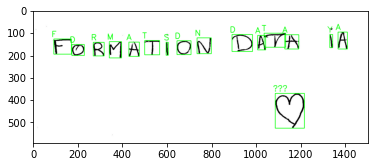

In [13]:
### Montre l'image ###
plt.imshow(image)

## Récupération du texte dans l'image

In [ ]:
# La récupération sera effectué via une lecture de l'image par une grille de matrice
# La lecture se fait de gauche à droite et de haut en bas
# La lecture commence de haut à gauche
# L'image est divisée en plusieurs case de sorte à former une grille
# Une vérification est effecutée à chaque case
# Si une détection est valide, elle est ajoutée au string "resultat"


resultat = ""

# Récupération de la taille de l'image
height, width = imgray.shape

# Pour créer la grille il faut convertir les valeur permettant d'afficher les contours 
conversionX = width / 48
conversionY = height / 200

#Comme ce sont des flottantes, il faut les convertir en entier
resultatX = int(conversionX)
resultatY = int(conversionY)

#Cette série de 3 boucles fonctionnent dans cet ordre :
#- Recherche dans la ligne
#- Recherche dans la colonne
#- Recherche dans la liste des caractères trouvés
for repereY in range(resultatY):
    for repereX in range(resultatX):
        for repere in range(len(detectionX)):
            #Si les valeurs sont toutes à 0, rien n'est trouvé, on passe
            if (detectionX[repere] != 0 and detectionY[repere] != 0 and caractere[repere] != 0):

                #Le but est de vérifier que le caractère sélectionné dans le tableau si ce n'est pas le cas, on signale qu'il faut faire une exception
                exception = 0
                if (detectionX[repere] < (repereX * 48) - 48):
                    exception = 1
                if (detectionX[repere] > (repereX * 48) + 48):
                    exception = 1
                if (detectionY[repere] < (repereY * 200) - 200):
                    exception = 1
                if (detectionY[repere] > (repereY * 200) + 200):
                    exception = 1

                if (exception == 0):
                    memoX = detectionX[repere]
                    memoY = detectionY[repere]
                    resultat = resultat + str(caractere[repere])

#Affichage du résultat final
print(resultat)